In [1]:
#Import All the Required Libraries..
import numpy as np
import pandas as pd
import re
from tqdm import tqdm, tqdm_pandas
tqdm_pandas(tqdm())
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors

0it [00:00, ?it/s]


In [2]:
#import test and train data into dataframe..
os.getcwd()
os.chdir('/Users/amitagarwal/GreyAtom/Hackathon/hotstar_dataset')
train_data = pd.read_json('train_data.json',orient='index')
test_data = pd.read_json('test_data.json',orient='index')

In [3]:
train_data.head

<bound method NDFrame.head of                                                          cities  \
train-121672                               delhi:3492,mumbai:64   
train-121673                       ahmedabad:56666,mumbai:26989   
train-121670                                  navi mumbai:29400   
train-121671               chennai:77,navi mumbai:4005,mumbai:0   
train-121676      bangalore:5135,krishnarajapura:529,hosur:2864   
train-121677                                        bangalore:5   
train-121674              gurgaon:12635,delhi:13142,nagari:3885   
train-121675               bangalore:373,chennai:6205,mumbai:77   
train-121678               gurgaon:1124,delhi:9492,mumbai:19504   
train-121679                          rawalpindi:976,lahore:104   
train-199734                kolkata:16889,delhi:180,chennai:245   
train-193747  kolkata:143,gurgaon:84201,chennai:25671,mumbai...   
train-123292                            kolkata:2490,mumbai:329   
train-123293                    

In [4]:
#set index
train_data.reset_index(level = 0, inplace = True)
train_data.rename(columns={'index':'ID'}, inplace=True)

test_data.reset_index(level = 0, inplace = True)
test_data.rename(columns={'index':'ID'}, inplace=True)

In [5]:
train_data.columns

Index(['ID', 'cities', 'dow', 'genres', 'segment', 'titles', 'tod'], dtype='object')

In [6]:
#check data
print ('Train data Number of rows {} rows and {} columns'.format(train_data.shape[0],train_data.shape[1]))
print ('test_data data Number of rows {} rows and {} columns'.format(test_data.shape[0],test_data.shape[1]))

Train data Number of rows 200000 rows and 7 columns
test_data data Number of rows 100000 rows and 6 columns


In [7]:
#Encode Target Variable
train_data = train_data.replace({'segment':{'pos':1,'neg':0}})


In [8]:
test_data = test_data.replace({'segment':{'pos':1,'neg':0}})

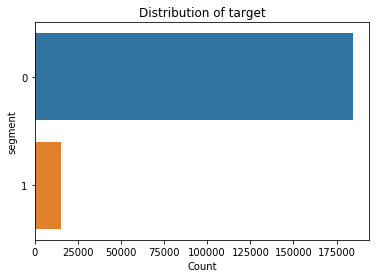

In [9]:
# Plotting distribution of Segments:
sns.countplot(y='segment', data=train_data)
plt.ylabel('segment')
plt.xlabel('Count')
plt.title('Distribution of target')
plt.show()

In [10]:
#check target variable count
train_data['segment'].value_counts()/train_data.shape[0]

0    0.923725
1    0.076275
Name: segment, dtype: float64

In [11]:
# Creating separate columns for genres
genre_data = [[str("genre_" + i) for i in re.sub(pattern='\:\d+',repl='',string=x).split(",")] for x in train_data['genres']]
genre_data = frozenset.union(*pd.Series(genre_data).apply(frozenset))

In [12]:
cities_data = [[str("cities_" + i) for i in re.sub(pattern='\:\d+', repl='', string = x).split(',')] for x in train_data['cities']]
cities_data = frozenset.union(*pd.Series(cities_data).apply(frozenset))

In [13]:
dow_data = [[str("dow_" + i) for i in re.sub(pattern='\:\d+', repl='', string = x).split(',')] for x in train_data['dow']]
dow_data = frozenset.union(*pd.Series(dow_data).apply(frozenset))

In [14]:
tod_data = [[str("tod_" + i) for i in re.sub(pattern='\:\d+', repl='', string = x).split(',')] for x in train_data['tod']]
tod_data = frozenset.union(*pd.Series(tod_data).apply(frozenset))

In [15]:
def get_genre_freq(row):
        
    genre_dict = {}
    for genre in row.genres.split(","):
        genre_name, genre_wt = genre.split(":")
        genre_dict[str("genre_" + genre_name)] = int(genre_wt)
    
    genre_freq = {}
    for i in genre_data:
        if i in genre_dict:
            genre_freq[i] = genre_dict[i] 
        else:
            genre_freq[i] = 0            

    return pd.Series(genre_freq)

In [16]:
genre_feats = train_data.progress_apply(get_genre_freq, axis = 1)

200001it [01:59, 1674.66it/s]


In [17]:
def get_dow_freq(row):
    
    dow_dict = {}
    for dow in row.dow.split(","):
        dow_name, dow_wt = dow.split(":")
        dow_dict[str("dow_" + dow_name)] = int(dow_wt)
    
    dow_freq = {}
    for i in dow_data:
        if i in dow_dict:
            dow_freq[i] = dow_dict[i] 
        else:
            dow_freq[i] = 0            

    return pd.Series(dow_freq)

def get_tod_freq(row):
    
    tod_dict = {}
    for tod in row.tod.split(","):
        tod_name, tod_wt = tod.split(":")
        tod_dict[str("tod_" + tod_name)] = int(tod_wt)
    
    tod_freq = {}
    for i in tod_data:
        if i in tod_dict:
            tod_freq[i] = tod_dict[i] 
        else:
            tod_freq[i] = 0            

    return pd.Series(tod_freq)

In [18]:
dow_feats = train_data.progress_apply(get_dow_freq, axis = 1)
tod_feats = train_data.progress_apply(get_tod_freq, axis = 1)

100%|██████████| 200000/200000 [01:22<00:00, 2423.25it/s]


In [19]:
train_data = pd.concat([train_data, genre_feats], axis = 1)
train_data = pd.concat([train_data, dow_feats], axis = 1)
train_data = pd.concat([train_data, tod_feats], axis = 1)

In [20]:
genre_feats = test_data.progress_apply(get_genre_freq, axis = 1)
dow_feats = test_data.progress_apply(get_dow_freq, axis = 1)
tod_feats = test_data.progress_apply(get_tod_freq, axis = 1)

test_data = pd.concat([test_data, genre_feats], axis = 1)
test_data = pd.concat([test_data, dow_feats], axis = 1)
test_data = pd.concat([test_data, tod_feats], axis = 1)

100%|██████████| 100000/100000 [00:49<00:00, 2015.22it/s]


In [21]:
metro_cities = ['mumbai','delhi','kolkata','chennai','bengaluru','hyderabad','ahmadabad','pune','surat','jaipur','kanpur','lucknow','nagpur','ghaziabad','indore','coimbatore','kochi','patna','kozhikode','bhopal','thrissur','vadodara','agra','malappuram','thiruvananthapuram','kannur','ludhiana','nashik','vijayawada','madurai','varanasi','meerut','faridabad','rajkot','jamshedpur','srinagar','jabalpur','asansol','vasai virar city','allahabad','dhanbad','aurangabad','amritsar','jodhpur','ranchi','raipur','kollam','gwalior','durg-bhilainagar','chandigarh','tiruchirappalli','kota']
cities_metro = ['metro','non_metro']
def get_Metro_freq(row):
    cities_dict = {}
    for city in row.cities.split(","):
        city_name, city_wt = city.split(":")
        if city_name.lower() in metro_cities:
            cities_dict[str("metro")] = int(city_wt)
        else:
            cities_dict[str("non_metro")] = int(city_wt)   
    
    metro_freq = {}
    for x in cities_metro:
        if x in cities_dict:
            metro_freq[x] = cities_dict[x]
        else:
            metro_freq[x] = 0            

    return pd.Series(metro_freq)

In [22]:
metro_feats = train_data.progress_apply(get_Metro_freq, axis = 1)

100%|██████████| 200000/200000 [01:17<00:00, 2589.86it/s]


In [23]:
train_data = pd.concat([train_data, metro_feats], axis = 1)
metro_feats

,metro,non_metro
0,64,0
1,26989,56666
2,0,29400
3,0,4005
4,0,2864
5,0,5
6,13142,3885
7,77,373
8,19504,1124
9,0,104


In [24]:
metro_feats = test_data.progress_apply(get_Metro_freq, axis = 1)
test_data = pd.concat([test_data, metro_feats], axis = 1)

100%|██████████| 100000/100000 [00:39<00:00, 2551.20it/s]


In [25]:
# sum of watch time from titles

def get_sum_wt(row):
    
    sum_wt = 0
    
    for title in row.titles.split(","):

        try: #to ignore blanks

            title_name, title_wt = title.split(":")
            sum_wt += int(title_wt)
            
        except:
            pass
        
    return sum_wt

train_data["sum_wt"] = train_data.progress_apply(get_sum_wt, axis = 1)
test_data["sum_wt"] = test_data.progress_apply(get_sum_wt, axis = 1)

100%|██████████| 100000/100000 [00:07<00:00, 14100.17it/s]


In [26]:
#Create Count variables
def get_count(feature):
    return feature.count(',')+1

train_data['title_count'] = train_data['titles'].map(get_count)
train_data['genres_count'] = train_data['genres'].map(get_count)
train_data['cities_count'] = train_data['cities'].map(get_count)
train_data['tod_count'] = train_data['tod'].map(get_count)
train_data['dow_count'] = train_data['dow'].map(get_count)

#test_data['title_count'] = test_data['titles'].map(get_count)
#test_data['genres_count'] = test_data['genres'].map(get_count)
#test_data['cities_count'] = test_data['cities'].map(get_count)
#test_data['tod_count'] = test_data['tod'].map(get_count)
#test_data['dow_count'] = test_data['dow'].map(get_count)



In [27]:
dow_1_sum= train_data['dow_1'].sum()
dow_2_sum= train_data['dow_2'].sum()
dow_3_sum= train_data['dow_3'].sum()
dow_4_sum= train_data['dow_4'].sum()
dow_5_sum= train_data['dow_5'].sum()
dow_6_sum= train_data['dow_6'].sum()
dow_7_sum= train_data['dow_7'].sum()
dow_sum=[dow_1_sum, dow_2_sum, dow_3_sum, dow_4_sum, dow_5_sum, dow_6_sum, dow_7_sum]
dow_sum

[565542985, 543678498, 540798186, 659711445, 593545037, 624329762, 721431991]

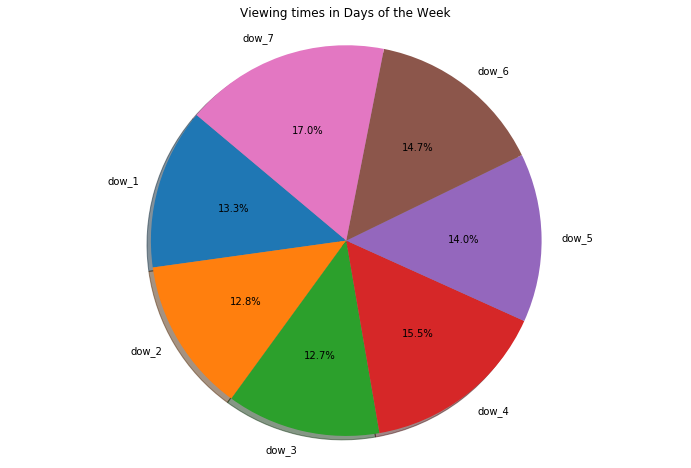

In [28]:
days_of_week = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'red','yellow', 'cyan']
plt.figure(figsize=(12,8))
plt.pie(dow_sum, labels=['dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6','dow_7'],
       autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Viewing times in Days of the Week')
plt.show()

In [29]:
train_data.drop(['cities','dow','genres','titles','tod'], inplace=True, axis=1)
#test_data.drop(['cities','dow','genres','titles','tod'], inplace=True, axis=1)

In [30]:
test_data.drop(['cities','dow','genres','titles','tod'], inplace=True, axis=1)

In [31]:
train_data.to_csv('final_train_test.csv')

In [32]:
test_data.to_csv('final_test.csv')

In [33]:
#new_data_frame = train_data.copy()
#train_data = new_data_frame

In [34]:
train_data.columns


Index(['ID', 'segment', 'genre_Tennis', 'genre_IndiaVsSa', 'genre_Sport',
       'genre_Travel', 'genre_Action', 'genre_Horror', 'genre_Athletics',
       'genre_Documentary', 'genre_Kids', 'genre_Table Tennis', 'genre_Family',
       'genre_Reality', 'genre_Awards', 'genre_Thriller', 'genre_Hockey',
       'genre_Football', 'genre_Badminton', 'genre_Formula1', 'genre_Kabaddi',
       'genre_Crime', 'genre_Science', 'genre_Teen', 'genre_NA',
       'genre_LiveTV', 'genre_Wildlife', 'genre_Comedy', 'genre_Drama',
       'genre_TalkShow', 'genre_FormulaE', 'genre_Volleyball', 'genre_Boxing',
       'genre_Cricket', 'genre_Mythology', 'genre_Swimming', 'genre_Romance',
       'dow_1', 'dow_3', 'dow_2', 'dow_5', 'dow_6', 'dow_4', 'dow_7', 'tod_6',
       'tod_3', 'tod_13', 'tod_14', 'tod_21', 'tod_7', 'tod_15', 'tod_23',
       'tod_9', 'tod_1', 'tod_2', 'tod_5', 'tod_8', 'tod_17', 'tod_20',
       'tod_19', 'tod_4', 'tod_10', 'tod_18', 'tod_12', 'tod_16', 'tod_11',
       'tod_0', 'tod_22

In [35]:
def similar_genre_feature(df):
    
    sports_feats = ["genre_Athletics" , "genre_Badminton" , "genre_Boxing" , "genre_Cricket" , "genre_Football" , "genre_Formula1" , "genre_FormulaE" , "genre_Hockey" , "genre_IndiaVsSa" , "genre_Kabaddi" , "genre_Sport" , "genre_Swimming" , "genre_Table Tennis" , "genre_Tennis" , "genre_Volleyball"]
    df["generated_sports"] = 0
    
    remaining_genres = ["genre_Comedy", "genre_Drama", "genre_Family", "genre_Reality", "genre_Romance", "genre_TalkShow", "genre_Thriller"]
    #df["generated_positive"] = 0

    remaining_genres = []
    
    for i in df.columns:
        if "genre_" in i and i not in sports_feats:
            remaining_genres.append(i)
    

    for i in sports_feats:
        df["generated_sports"]  = df["generated_sports"] + df[i]
        df.drop(i, axis = 1, inplace = True)

    sum_wt = sum([df[i] for i in remaining_genres])
    sum_wt += df["generated_sports"]
    
    df["generated_sports_ratio"] = df["generated_sports"]/sum_wt    
    
    for i in remaining_genres:
        df[i+"_ratio"] = df[i]/sum_wt
            
    return df

In [36]:
def generate_tod_features(df):
    night_feats = ["tod_0", "tod_1", "tod_2", "tod_3", "tod_4", "tod_5"]
    df["generated_night"] = 0
    
    morning_feats = ["tod_6", "tod_7", "tod_8", "tod_9", "tod_10", "tod_11"]    
    df["generated_morning"] = 0
    
    afternoon_feats = ["tod_12", "tod_13", "tod_14", "tod_15", "tod_16", "tod_17"]    
    df["generated_afternoon"] = 0
    
    evening_feats = [ "tod_18", "tod_19", "tod_20", "tod_21", "tod_22", "tod_23"]    
    df["generated_evening"] = 0

    for i in night_feats:
        df["generated_night"] += df[i]
        df.drop(i, axis = 1, inplace = True)

    for i in morning_feats:
        df["generated_morning"] += df[i]
        df.drop(i, axis = 1, inplace = True)
        
    for i in afternoon_feats:
        df["generated_afternoon"] += df[i]
        df.drop(i, axis = 1, inplace = True)

    for i in evening_feats:
        df["generated_evening"] += df[i]
        df.drop(i, axis = 1, inplace = True)

    sum_wt = df["generated_night"] + df["generated_morning"] + df["generated_afternoon"] + df["generated_evening"]

    df["night_tod_ratio"] = df["generated_night"]/sum_wt
    df["morning_tod_ratio"] = df["generated_morning"]/sum_wt
    df["afternoon_tod_ratio"] = df["generated_afternoon"]/sum_wt                                                  
    df["evening_tod_ratio"] = df["generated_evening"]/sum_wt
    
    return df

In [37]:
def generate_wod_features(df):

    weekday_feats = ["dow_1", "dow_2", "dow_3", "dow_4", "dow_5", "dow_6", "dow_7"]
    sum_wt = sum([df[i] for i in weekday_feats])
    df["weekend_ratio"] = (df["dow_7"] + df["dow_6"])/sum_wt
    df["weekday_ratio"] = 1 - df["weekend_ratio"]
    
    return df

In [38]:
def generate_cities_features(df):
    sum_wt = df["metro"] + df["non_metro"]
    df["metro_ratio"] = df["metro"]/sum_wt
    df["non_metro_ratio"] = df["non_metro"]/sum_wt
    return df

In [39]:
df_new = similar_genre_feature(train_data)

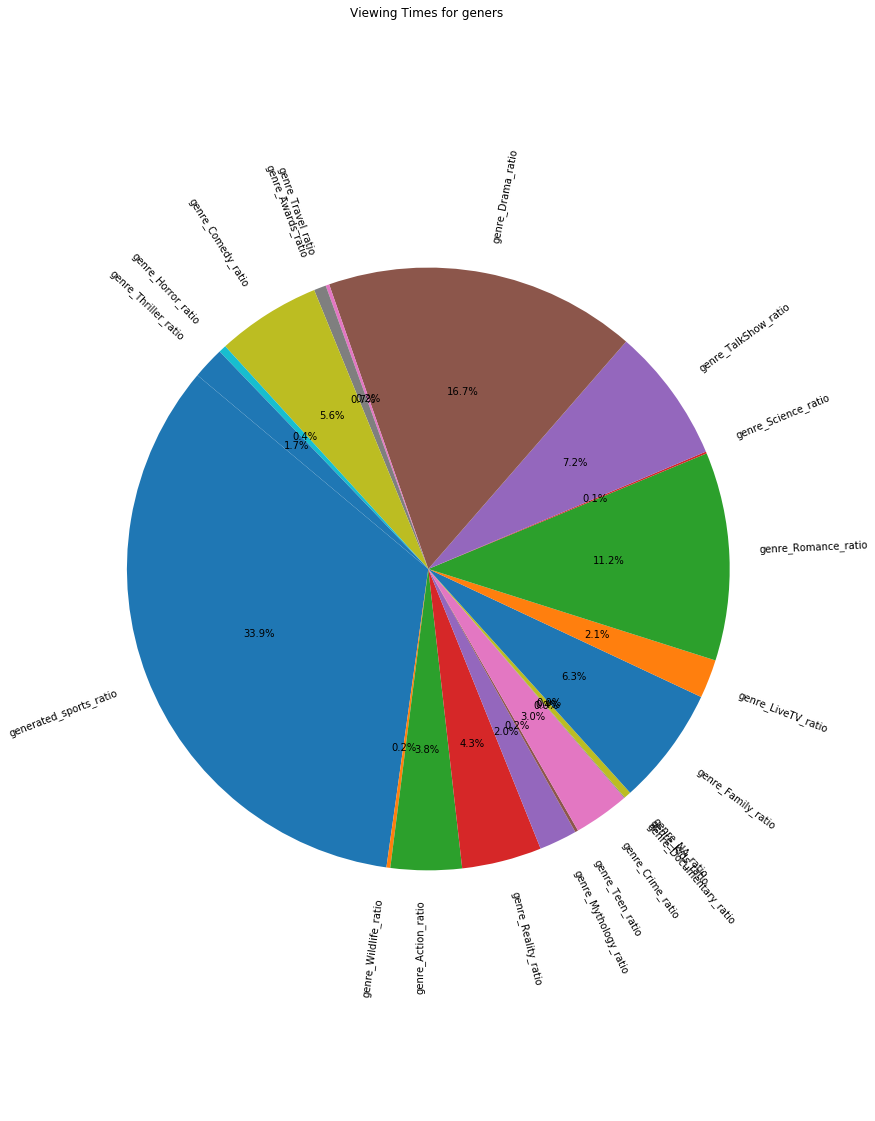

In [40]:
labels = ['generated_sports_ratio', 'genre_Wildlife_ratio',
       'genre_Action_ratio', 'genre_Reality_ratio', 'genre_Mythology_ratio',
       'genre_Teen_ratio', 'genre_Crime_ratio', 'genre_Documentary_ratio',
       'genre_Kids_ratio', 'genre_NA_ratio', 'genre_Family_ratio',
       'genre_LiveTV_ratio', 'genre_Romance_ratio', 'genre_Science_ratio',
       'genre_TalkShow_ratio', 'genre_Drama_ratio', 'genre_Travel_ratio',
       'genre_Awards_ratio', 'genre_Comedy_ratio', 'genre_Horror_ratio',
       'genre_Thriller_ratio']

sum_geners = [df_new['generated_sports_ratio'].sum(), df_new['genre_Wildlife_ratio'].sum(),
       df_new['genre_Action_ratio'].sum(), df_new['genre_Reality_ratio'].sum(), df_new['genre_Mythology_ratio'].sum(),
       df_new['genre_Teen_ratio'].sum(), df_new['genre_Crime_ratio'].sum(), df_new['genre_Documentary_ratio'].sum(),
       df_new['genre_Kids_ratio'].sum(), df_new['genre_NA_ratio'].sum(), df_new['genre_Family_ratio'].sum(),
       df_new['genre_LiveTV_ratio'].sum(), df_new['genre_Romance_ratio'].sum(), df_new['genre_Science_ratio'].sum(),
       df_new['genre_TalkShow_ratio'].sum(), df_new['genre_Drama_ratio'].sum(), df_new['genre_Travel_ratio'].sum(),
       df_new['genre_Awards_ratio'].sum(), df_new['genre_Comedy_ratio'].sum(), df_new['genre_Horror_ratio'].sum(),
       df_new['genre_Thriller_ratio'].sum()]
plt.figure(figsize=(12,20))
plt.pie(sum_geners, labels=labels,
       autopct='%1.1f%%',  startangle=140, rotatelabels=True)
plt.axis('equal')
plt.title('Viewing Times for geners')
plt.show()

In [41]:
df_new = generate_tod_features(train_data)

In [42]:
tod_sum_wt = [df_new["generated_night"].sum() , df_new["generated_afternoon"].sum() , df_new["generated_evening"].sum(),df_new["generated_morning"].sum()]
tod_sum_wt

[545548434, 1426059749, 1610752873, 666613752]

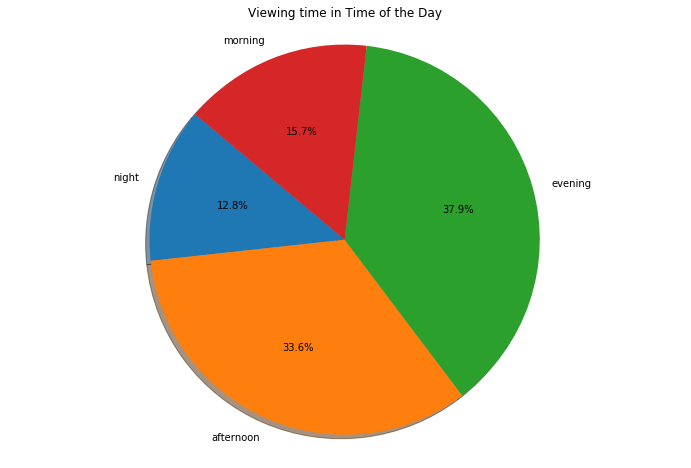

In [43]:
colors_tod = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
plt.figure(figsize=(12,8))
plt.pie(tod_sum_wt, labels=['night','afternoon','evening','morning'],
       autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Viewing time in Time of the Day')
plt.show()

In [44]:
df_new = generate_wod_features(train_data)

In [45]:
df_new  = generate_cities_features(train_data)

In [46]:
df_new.to_csv('train_data_new.csv')

In [47]:
df_test_new = generate_tod_features(test_data)
df_test_new = similar_genre_feature(test_data)
df_test_new = generate_wod_features(test_data)
df_test_new  = generate_cities_features(test_data)

In [48]:
df_test_new.to_csv('test_data_new.csv')

/Users/amitagarwal/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


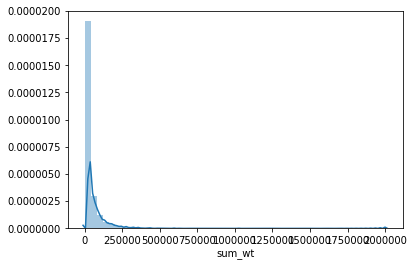

In [49]:
sns.distplot(df_new[df_new.segment == 1].sum_wt)
plt.show()

/Users/amitagarwal/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


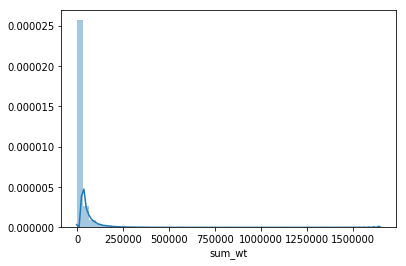

In [50]:
sns.distplot(df_new[df_new.segment == 0].sum_wt)
plt.show()

In [51]:
df_new[df_new.segment == 1].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
segment,15255.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000e+00
genre_Travel,15255.0,18.876762,542.217385,0.0,0.000000,0.000000,0.000000,4.590700e+04
genre_Action,15255.0,368.571878,2618.270846,0.0,0.000000,0.000000,0.000000,1.695550e+05
genre_Horror,15255.0,66.417437,1009.797066,0.0,0.000000,0.000000,0.000000,5.945500e+04
genre_Documentary,15255.0,5.407670,211.113174,0.0,0.000000,0.000000,0.000000,1.784900e+04
genre_Kids,15255.0,89.414094,1172.613528,0.0,0.000000,0.000000,0.000000,5.317900e+04
genre_Family,15255.0,5233.363618,18905.027152,0.0,0.000000,0.000000,1531.500000,6.753350e+05
genre_Reality,15255.0,963.399869,5546.414251,0.0,0.000000,0.000000,1.000000,2.126130e+05
genre_Awards,15255.0,99.228581,894.318523,0.0,0.000000,0.000000,0.000000,2.351300e+04
genre_Thriller,15255.0,541.268305,3985.904272,0.0,0.000000,0.000000,0.000000,1.655000e+05


In [52]:
Columns_needs_to_drop = ["generated_evening","generated_night","generated_afternoon","generated_morning","dow_1","dow_2","dow_3","dow_4","dow_5","dow_6","dow_7","metro","non_metro"]
df_new.drop(Columns_needs_to_drop,axis=1,inplace = True)

remaining_genres_columns = ["genre_Comedy", "genre_Drama", "genre_Family", "genre_Reality", "genre_Romance", "genre_TalkShow", "genre_Thriller","sum_wt"]
df_new.drop(remaining_genres_columns,axis=1,inplace = True)

somemore_genres_columns = ["genre_Action", "genre_Documentary", "genre_Mythology", "genre_Teen", "genre_Crime", "genre_Kids", "genre_Science","genre_Horror","genre_Awards","genre_Travel","genre_NA","genre_LiveTV","genre_Wildlife","generated_sports"]
df_new.drop(somemore_genres_columns,axis=1,inplace = True)

In [53]:
Columns_needs_to_drop = ["generated_evening","generated_night","generated_afternoon","generated_morning","dow_1","dow_2","dow_3","dow_4","dow_5","dow_6","dow_7","metro","non_metro"]
df_test_new.drop(Columns_needs_to_drop,axis=1,inplace = True)

remaining_genres_columns = ["genre_Comedy", "genre_Drama", "genre_Family", "genre_Reality", "genre_Romance", "genre_TalkShow", "genre_Thriller","sum_wt"]
df_test_new.drop(remaining_genres_columns,axis=1,inplace = True)

somemore_genres_columns = ["genre_Action", "genre_Documentary", "genre_Mythology", "genre_Teen", "genre_Crime", "genre_Kids", "genre_Science","genre_Horror","genre_Awards","genre_Travel","genre_NA","genre_LiveTV","genre_Wildlife","generated_sports"]
df_test_new.drop(somemore_genres_columns,axis=1,inplace = True)

In [54]:
#somemore_genres_columns = ["genre_LiveTV","genre_Wildlife","generated_sports"]
#df_test_new.drop(somemore_genres_columns,axis=1,inplace = True)

df_new.head(5)

,ID,segment,title_count,genres_count,cities_count,tod_count,dow_count,generated_sports_ratio,genre_Travel_ratio,genre_Action_ratio,...,genre_Mythology_ratio,genre_Romance_ratio,night_tod_ratio,morning_tod_ratio,afternoon_tod_ratio,evening_tod_ratio,weekend_ratio,weekday_ratio,metro_ratio,non_metro_ratio
0,train-121672,0,9,3,2,3,3,0.976083,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.090039,0.909961,0.018008,0.981992,1.000000,0.000000
1,train-121673,0,33,6,2,18,7,0.000000,0.0,0.024678,...,0.0,0.198130,0.300951,0.158450,0.237425,0.303175,0.485264,0.514736,0.322623,0.677377
2,train-121670,0,17,6,1,16,7,0.194401,0.0,0.000476,...,0.0,0.000000,0.000000,0.301504,0.176453,0.522044,0.272758,0.727242,0.000000,1.000000
3,train-121671,0,3,3,3,5,3,0.951249,0.0,0.000000,...,0.0,0.018863,0.000000,0.029887,0.970113,0.000000,0.000000,1.000000,0.000000,1.000000
4,train-121676,1,1,1,3,6,2,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000


In [55]:
df_new[df_new.segment == 1].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
segment,15255.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000
title_count,15255.0,8.012455,9.835222,1.0,2.000000,5.000000,10.000000,186.000000
genres_count,15255.0,3.247263,2.071606,1.0,2.000000,3.000000,4.000000,18.000000
cities_count,15255.0,2.058276,1.352105,1.0,1.000000,2.000000,3.000000,16.000000
tod_count,15255.0,8.806490,6.005727,1.0,3.000000,8.000000,13.000000,24.000000
dow_count,15255.0,4.496296,2.284612,1.0,2.000000,5.000000,7.000000,7.000000
generated_sports_ratio,15255.0,0.054075,0.190283,0.0,0.000000,0.000000,0.000000,1.000000
genre_Travel_ratio,15255.0,0.000809,0.018425,0.0,0.000000,0.000000,0.000000,1.000000
genre_Action_ratio,15255.0,0.018738,0.105561,0.0,0.000000,0.000000,0.000000,1.000000
genre_Horror_ratio,15255.0,0.004110,0.051497,0.0,0.000000,0.000000,0.000000,1.000000


In [56]:
dropping_columns = ["ID", "dow_count", "tod_count", "genres_count", "cities_count", "title_count"]
df_new.drop(dropping_columns,axis=1,inplace = True)

In [57]:
dropping_columns = ["ID"]
df_test_new.drop(dropping_columns,axis=1,inplace = True)

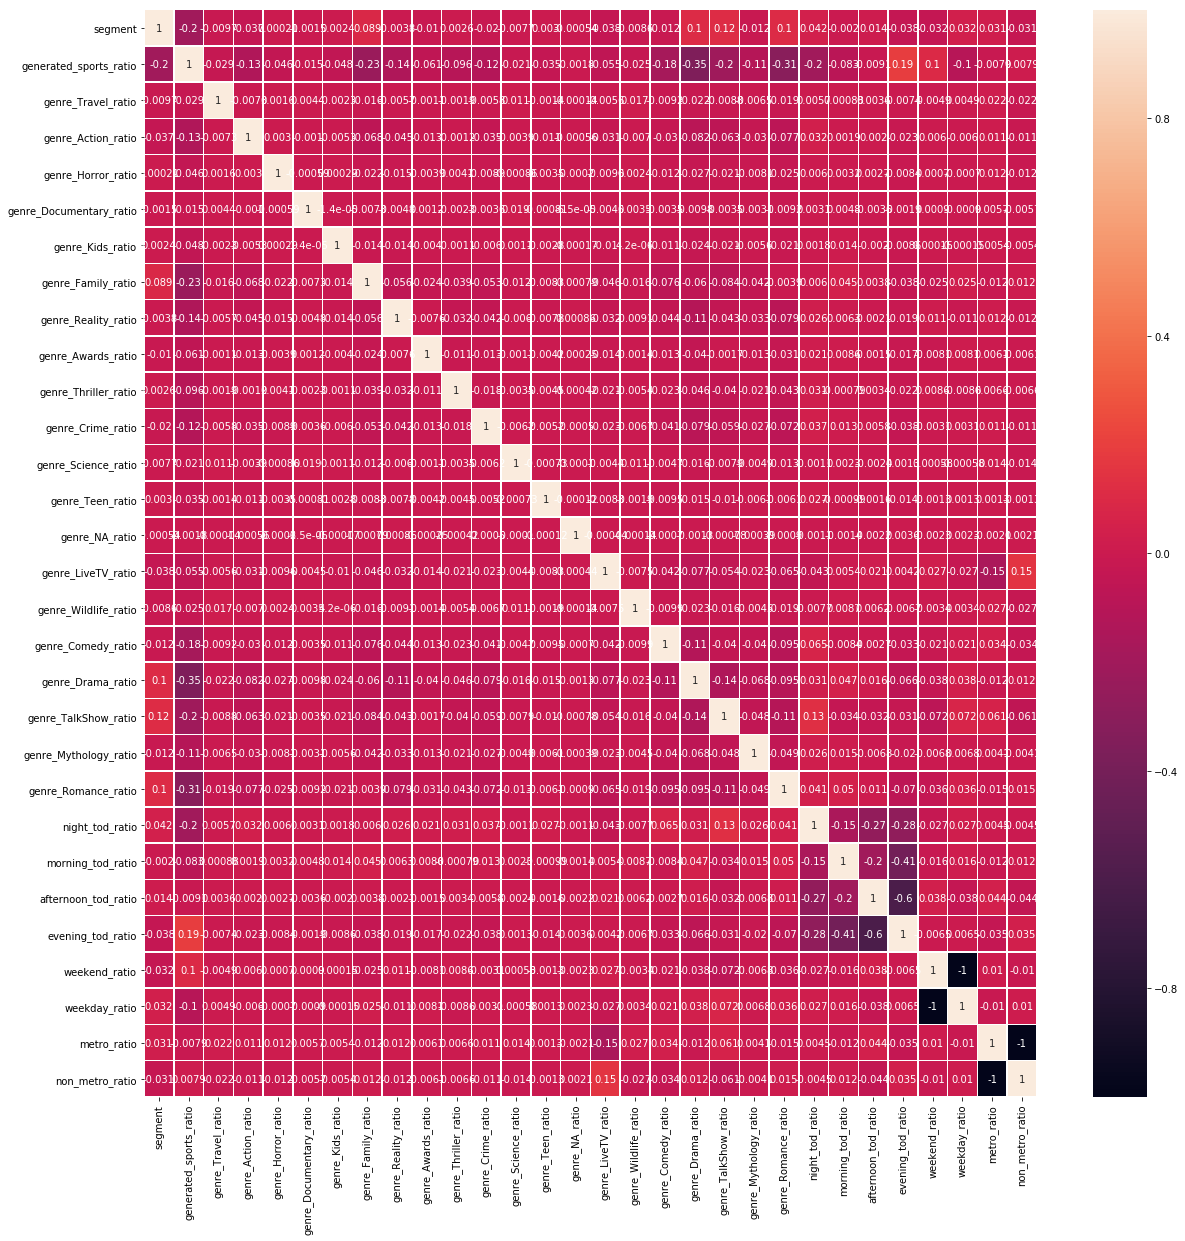

In [58]:
Var_Corr = df_new.corr()
# plot the heatmap and annotation on it
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True,linewidths=.5, ax=ax)

In [59]:
import matplotlib.pyplot as plt
plt.show()

In [60]:
# Plotting distribution of Segments:
#sns.countplot(y='metro_ratio', data=df_new)
#plt.ylabel('matro_ratio')
#plt.xlabel('Count')
#plt.title('Distribution of metros')
#plt.show()

In [61]:
df_new.to_csv('intermidate_state.csv')

In [62]:
df_new[df_new.segment == 1].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
segment,15255.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000
generated_sports_ratio,15255.0,0.054075,0.190283,0.0,0.000000,0.000000,0.000000,1.000000
genre_Travel_ratio,15255.0,0.000809,0.018425,0.0,0.000000,0.000000,0.000000,1.000000
genre_Action_ratio,15255.0,0.018738,0.105561,0.0,0.000000,0.000000,0.000000,1.000000
genre_Horror_ratio,15255.0,0.004110,0.051497,0.0,0.000000,0.000000,0.000000,1.000000
genre_Documentary_ratio,15255.0,0.000348,0.014432,0.0,0.000000,0.000000,0.000000,0.980861
genre_Kids_ratio,15255.0,0.004130,0.048697,0.0,0.000000,0.000000,0.000000,1.000000
genre_Family_ratio,15255.0,0.122802,0.249911,0.0,0.000000,0.000000,0.110684,1.000000
genre_Reality_ratio,15255.0,0.040708,0.155611,0.0,0.000000,0.000000,0.000013,1.000000
genre_Awards_ratio,15255.0,0.004353,0.047546,0.0,0.000000,0.000000,0.000000,1.000000


In [63]:
df_new.to_csv('intermidate_state.csv')

In [64]:
#30 Features 
df_new.shape

(200000, 30)

In [65]:
df_test_new.shape

(100000, 29)

In [66]:
df_test_new[df_new.segment == 1].describe().transpose()

/Users/amitagarwal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,count,mean,std,min,25%,50%,75%,max
night_tod_ratio,7552.0,0.104841,0.223846,0.0,0.000000,0.000000,0.086322,1.000000
morning_tod_ratio,7552.0,0.138985,0.234613,0.0,0.000000,0.018586,0.181046,1.000000
afternoon_tod_ratio,7552.0,0.327197,0.318086,0.0,0.009734,0.254663,0.529071,1.000000
evening_tod_ratio,7552.0,0.428977,0.346156,0.0,0.103863,0.381930,0.713164,1.000000
generated_sports_ratio,7552.0,0.316528,0.399261,0.0,0.000000,0.019600,0.747262,0.999962
genre_Travel_ratio,7552.0,0.001942,0.034550,0.0,0.000000,0.000000,0.000000,1.000000
genre_Action_ratio,7552.0,0.036584,0.148080,0.0,0.000000,0.000000,0.000000,1.000000
genre_Horror_ratio,7552.0,0.003993,0.050218,0.0,0.000000,0.000000,0.000000,1.000000
genre_Documentary_ratio,7552.0,0.000568,0.016471,0.0,0.000000,0.000000,0.000000,1.000000
genre_Kids_ratio,7552.0,0.003424,0.046572,0.0,0.000000,0.000000,0.000000,1.000000


In [67]:
df_new.columns

Index(['segment', 'generated_sports_ratio', 'genre_Travel_ratio',
       'genre_Action_ratio', 'genre_Horror_ratio', 'genre_Documentary_ratio',
       'genre_Kids_ratio', 'genre_Family_ratio', 'genre_Reality_ratio',
       'genre_Awards_ratio', 'genre_Thriller_ratio', 'genre_Crime_ratio',
       'genre_Science_ratio', 'genre_Teen_ratio', 'genre_NA_ratio',
       'genre_LiveTV_ratio', 'genre_Wildlife_ratio', 'genre_Comedy_ratio',
       'genre_Drama_ratio', 'genre_TalkShow_ratio', 'genre_Mythology_ratio',
       'genre_Romance_ratio', 'night_tod_ratio', 'morning_tod_ratio',
       'afternoon_tod_ratio', 'evening_tod_ratio', 'weekend_ratio',
       'weekday_ratio', 'metro_ratio', 'non_metro_ratio'],
      dtype='object')

In [68]:
df_test_new.columns

Index(['night_tod_ratio', 'morning_tod_ratio', 'afternoon_tod_ratio',
       'evening_tod_ratio', 'generated_sports_ratio', 'genre_Travel_ratio',
       'genre_Action_ratio', 'genre_Horror_ratio', 'genre_Documentary_ratio',
       'genre_Kids_ratio', 'genre_Family_ratio', 'genre_Reality_ratio',
       'genre_Awards_ratio', 'genre_Thriller_ratio', 'genre_Crime_ratio',
       'genre_Science_ratio', 'genre_Teen_ratio', 'genre_NA_ratio',
       'genre_LiveTV_ratio', 'genre_Wildlife_ratio', 'genre_Comedy_ratio',
       'genre_Drama_ratio', 'genre_TalkShow_ratio', 'genre_Mythology_ratio',
       'genre_Romance_ratio', 'weekend_ratio', 'weekday_ratio', 'metro_ratio',
       'non_metro_ratio'],
      dtype='object')

In [69]:
df_test_new["segment"] = np.nan

In [70]:
df_test_new.to_csv('final_test_data.csv')

In [71]:
df_test_new = pd.read_csv('final_test_data.csv')

In [72]:
df_test_new["segment"] = np.nan

In [73]:
from __future__ import division
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split

/Users/amitagarwal/anaconda3/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [74]:
def run_xgb_5(x_train, label_train, x_valid = None, label_valid = None):

    # Set our parameters for xgboost
    params = {}
    params['objective'] = 'binary:logistic'
    params['eval_metric'] = 'auc'
    params['eta'] = 0.02
    params['max_depth'] = 5
    params['silent'] = 1
    params['min_child_weight'] = 0
    params['subsample'] = 0.8
    params['colsample_bytree'] = 0.8
    params['nthread'] = 13

    d_train = xgb.DMatrix(x_train, label=label_train)
    
    if x_valid is not None:
        d_valid = xgb.DMatrix(x_valid, label=label_valid)
        watchlist = [(d_train, 'train'), (d_valid, 'validation')]
    else:
        watchlist = [(d_train, 'train')]
        
    bst = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=50, verbose_eval=50)
    
    return bst

In [75]:
#Clean useless columns
df_train = df_new.drop("segment",axis=1)
df_train_target = df_new["segment"]
#df_new.drop("ID", axis = 1, inplace=True)

#Validation split
x_train, x_test, y_train, y_test = train_test_split(df_train, df_train_target, test_size=0.2, random_state=4242, stratify = df_train_target)


In [ ]:
#Validation Run
bst5 = run_xgb_5(x_train, y_train, x_test, y_test)


[0]	train-auc:0.745386	validation-auc:0.746027
Multiple eval metrics have been passed: 'validation-auc' will be used for early stopping.

Will train until validation-auc hasn't improved in 50 rounds.
[50]	train-auc:0.8076	validation-auc:0.801239
[100]	train-auc:0.811201	validation-auc:0.803919
[150]	train-auc:0.814453	validation-auc:0.805196
[200]	train-auc:0.81782	validation-auc:0.806036
[250]	train-auc:0.820804	validation-auc:0.806777
[300]	train-auc:0.823739	validation-auc:0.807119
[350]	train-auc:0.82615	validation-auc:0.807442


In [ ]:
from sklearn import metrics 


In [ ]:
from sklearn import metrics 
d_test = xgb.DMatrix(x_test)
p5_test = bst5.predict(d_test)

p5_test = np.where(p5_test > 0.2, 1, 0)

In [ ]:
print(metrics.confusion_matrix(y_test,p5_test))

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test,p5_test))

In [ ]:
import operator
importance = bst5.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df_imp = pd.DataFrame(importance, columns=['feature', 'fscore'])
df_imp['fscore'] = df_imp['fscore']/df_imp['fscore'].sum()

df_imp

In [ ]:
import operator
importance = bst5.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))
print("--"*10)
df_imp = pd.Series(bst5.get_fscore()).sort_values(ascending=False)
df_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
print("--"*10)

In [ ]:
bst5_roc_auc = roc_auc_score(y_test, (p5_test))
print('AUC_ROC Score is:' + str(bst5_roc_auc))

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, p5_test)
plt.figure()
plt.plot(fpr, tpr, label='NaiveBayes (area = %0.2f)' % bst5_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
#Find Roc_Auc Score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
XG5_Boost_roc_auc = roc_auc_score(y_test, (p5_test))
#print('AUC_ROC Score is:' + str(XG5_Boost_roc_auc))

In [ ]:
#Real Test Run + Submit
bst = run_xgb(df_train, df_train_target)

d_test = xgb.DMatrix(df_test_new)
p_test = bst.predict(d_test)

sub = pd.DataFrame()
#sub['ID'] = test_ids
sub['segment'] = p_test
#sub.to_csv("./subs/xgb_1.csv", index=False)



In [ ]:
def run_xgb(x_train, label_train, x_valid = None, label_valid = None):

    # Set our parameters for xgboost
    params = {}
    params['objective'] = 'binary:logistic'
    params['eval_metric'] = 'auc'
    params['eta'] = 0.02
    params['max_depth'] = 3
    params['silent'] = 1
    params['min_child_weight'] = 0
    params['subsample'] = 0.8
    params['colsample_bytree'] = 0.8
    params['nthread'] = 13

    d_train = xgb.DMatrix(x_train, label=label_train)
    
    if x_valid is not None:
        d_valid = xgb.DMatrix(x_valid, label=label_valid)
        watchlist = [(d_train, 'train'), (d_valid, 'validation')]
    else:
        watchlist = [(d_train, 'train')]
        
    bst = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=50, verbose_eval=50)
    
    return bst

In [ ]:
#Clean useless columns
df_train = df_new.drop("segment",axis=1)
df_train_target = df_new["segment"]
#df_new.drop("ID", axis = 1, inplace=True)

#Validation split
x_train, x_test, y_train, y_test = train_test_split(df_train, df_train_target, test_size=0.2, random_state=4242, stratify = df_train_target)


In [ ]:
#Validation Run
bst = run_xgb(x_train, y_train, x_test, y_test)


In [ ]:
from sklearn import metrics 
d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

p_test = np.where(p_test > 0.2, 1, 0)

In [ ]:
print(metrics.confusion_matrix(y_test,p_test))

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test,p_test))

In [ ]:
import operator
importance = bst.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))
print("--"*10)
df_imp = pd.Series(bst.get_fscore()).sort_values(ascending=False)
df_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
print("--"*10)

In [ ]:
bst3_roc_auc = roc_auc_score(y_test, (p_test))
print('AUC_ROC Score is:' + str(bst3_roc_auc))

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, p_test)
plt.figure()
plt.plot(fpr, tpr, label='NaiveBayes (area = %0.2f)' % bst3_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
import operator
importance = bst.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df_imp = pd.DataFrame(importance, columns=['feature', 'fscore'])
df_imp['fscore'] = df_imp['fscore']/df_imp['fscore'].sum()

df_imp

In [ ]:
def run_xgb_8(x_train, label_train, x_valid = None, label_valid = None):

    # Set our parameters for xgboost
    params = {}
    params['objective'] = 'binary:logistic'
    params['eval_metric'] = 'auc'
    params['eta'] = 0.02
    params['max_depth'] = 8
    params['silent'] = 1
    params['min_child_weight'] = 0
    params['subsample'] = 0.8
    params['colsample_bytree'] = 0.8
    params['nthread'] = 13

    d_train = xgb.DMatrix(x_train, label=label_train)
    
    if x_valid is not None:
        d_valid = xgb.DMatrix(x_valid, label=label_valid)
        watchlist = [(d_train, 'train'), (d_valid, 'validation')]
    else:
        watchlist = [(d_train, 'train')]
        
    bst = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=50, verbose_eval=50)
    
    return bst

In [ ]:
#Clean useless columns
df_train = df_new.drop("segment",axis=1)
df_train_target = df_new["segment"]
#df_new.drop("ID", axis = 1, inplace=True)

#Validation split
x_train, x_test, y_train, y_test = train_test_split(df_train, df_train_target, test_size=0.2, random_state=4242, stratify = df_train_target)


In [ ]:
#Validation Run
bst8 = run_xgb_8(x_train, y_train, x_test, y_test)


In [ ]:
from sklearn import metrics 
d_test = xgb.DMatrix(x_test)
p8_test = bst8.predict(d_test)

p8_test = np.where(p_test > 0.2, 1, 0)

In [ ]:
import operator
importance = bst8.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df_imp = pd.DataFrame(importance, columns=['feature', 'fscore'])
df_imp['fscore'] = df_imp['fscore']/df_imp['fscore'].sum()

df_imp

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test,p8_test))

In [ ]:
import operator
importance = bst8.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))
print("--"*10)
df_imp = pd.Series(bst.get_fscore()).sort_values(ascending=False)
df_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
print("--"*10)

In [ ]:
bst8_roc_auc = roc_auc_score(y_test, (p8_test))
print('AUC_ROC Score is:' + str(bst8_roc_auc))

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, p8_test)
plt.figure()
plt.plot(fpr, tpr, label='NaiveBayes (area = %0.2f)' % bst8_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
#Real Test Run + Submit
bst = run_xgb(df_train, df_train_target)

d_test = xgb.DMatrix(df_test_new)
p_final = bst5.predict(d_test)

sub = pd.DataFrame()
sub['segment'] = p_final


In [ ]:
#Real Test Run + Submit
bst = run_xgb(df_train, df_train_target)

d_test = xgb.DMatrix(df_test_new)
p_final = bst5.predict(d_test)